## What is this??
This is the currently best working code to generate a model of DCWGAN-GP,  
<!-- though I've somehow renamed it   -->
**DCGAN_WGP** stands for *Deep Convolutional GAN with Wasserstein loss with Gradient Policy*
    
v1 or just "Trying_better structure.ipynb" exists in the archive

## Imports

In [3]:
import os
import pathlib
from PIL import Image

import numpy as np
# from scipy.fft import fft2, fftshift
# import seaborn as sns
# from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
# import healpy as hp

import torch
import torch.autograd as autograd
import torch.nn as nn
from torch.autograd import Variable
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Important constants


In [4]:
# Model Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCALE_A = 1
SCALE_B = 1
LATENT_DIM = 32
N_CONV_LAYER_GEN = 5
N_CONV_LAYER_DISC = 5
KERNEL_SIZE = 4
PADDING = 1
OUTPUT_PADDING = 0
NCONV_FC_GEN = 64
NCOV_FC_DIS = 64

# Training parameters
N_EPOCHS = 500
N_CRITICS = 5
SAMPLE_INTERVALS = 5
SAVE_INTERVAL = 100
LEARNING_RATE = 5e-5
BETAS = (0.5, 0.9)
L_GP = 10.0     # Weight of the Gradient Policy cost
L_l1 = 0.0      # Weight of the L1 norm cost

# Data handling
TRAIN_DIR = '../input/MITACS/data__map_cutouts/train4' #'../data__map_cutouts/train_v3'
SAVING_DIR = '/kaggle/working/datasets_for_Statistician/multiple_blobs_' + str(LATENT_DIM) + '/generated_data/' 
BATCH_SIZE = 20
BATCHES_TO_SAVE = 250

## Data Linking

In [5]:
to_tensor = transforms.ToTensor()
random_flips_v = transforms.RandomVerticalFlip(0.5)
random_flips_h = transforms.RandomHorizontalFlip(0.5)
to_grayscale = transforms.Grayscale(1)

transform = transforms.Compose([
    to_grayscale,
    to_tensor,
    random_flips_h,
    random_flips_v
])

train_dir = pathlib.Path(TRAIN_DIR)  
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
dataLoader = DataLoader(dataset=train_data,
                     batch_size=BATCH_SIZE, 
                     shuffle=True,
                     drop_last=True)
len(list(train_data))

# images, labels = next(iter(dataLoader))
# print(images.shape)

5000

torch.Size([20, 1, 128, 128])
(128, 128, 1)


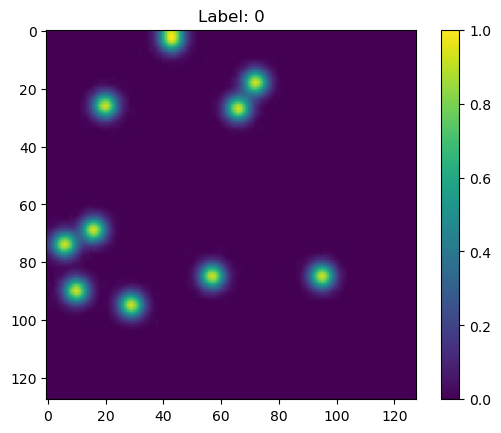

In [6]:
def plt_image(img, labels = None):
    images = img
    print(images.shape)
    if type(img) == torch.Tensor:
        images = img.detach().cpu().numpy()
    print(np.swapaxes(images[0, 0:1, :, :], 0, -1).shape)

    rand_idx = np.random.randint(0, BATCH_SIZE)
    to_plot = np.swapaxes(images[rand_idx, 0:1, :, :], 0, -1)
    # if to_plot.max() != 1:
    # to_plot = (to_plot + SCALE_A) / (2*SCALE_A)

    plt.imshow(to_plot)
    if labels != None:
        plt.title("Label: " + str(labels[rand_idx].item()))
    else:
        plt.title("Scaling factor b used: " + str(SCALE_B))
    plt.colorbar()
    plt.show()

images, labels = next(iter(dataLoader))
plt_image(images, labels)

## Some important layers
(nn.py)

In [7]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

class ScaledTanh(nn.Module):
    def __init__(self, a=SCALE_A, b=SCALE_B):
        super().__init__()
        self.a = a
        self.b = b

    def forward(self, sample):
        return torch.tanh(sample * self.b) * self.a
    

In [8]:
   
class LinearFeature(nn.Module):
    __constants__ = ['in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True):
        super(LinearFeature, self).__init__()
        assert(out_features == in_features)
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()


    def reset_parameters(self):
        nn.init.normal_(self.weight,1,0.02)
        if self.bias is not None:
            nn.init.normal_(self.bias,0,0.02)
    
    def forward(self, input):
        device = torch.device("cuda" if input.is_cuda else "cpu")
        eye = nn.Parameter(torch.zeros(input.shape), requires_grad=False).to(device=device)
        idxes = np.arange(input.shape[-1])
        eye[...,idxes, idxes] = 1.
        mat_weight = torch.einsum("i,...ijk->...ijk", self.weight, eye)

        if self.bias is not None:
            ones = nn.Parameter(torch.ones(input.shape), requires_grad=False).to(device=device)
            mat_bias = torch.einsum("i,...ijk->...ijk", self.bias, ones)

        return torch.matmul(input,mat_weight) if self.bias is None else torch.matmul(input,mat_weight) + mat_bias 

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


## DCGAN_Generator
(model.py)

In [9]:
class DCGAN_Generator(nn.Module):
    def __init__(self, shape, latent_dim, nconv_layer=2, nconv_fc=32, ngpu=1, kernel_size=5, stride=2, padding=2,
                 output_padding=1, activation=None):
        super().__init__()

        self.shape = shape
        self.nconv_layer = nconv_layer
        self.latent_dim = latent_dim
        self.ngpu = ngpu
        self.nconv_fc = nconv_fc
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.output_padding = output_padding
        self.ds_size = shape[-1] // self.stride ** self.nconv_layer
        self.activation = activation
        nconv_lc = nconv_fc * self.stride ** (self.nconv_layer - 1)
        # print(nconv_lc, nconv_fc, self.stride, shape[-1], self.nconv_layer)

        def _get_conv_layers(nconv_layer, nconv_lc):
            conv_layers = []
            for i in range(nconv_layer - 1):
                conv_layers.extend([nn.ConvTranspose2d(nconv_lc // self.stride ** i, 
                                                       nconv_lc // self.stride ** (i + 1),
                                                       self.kernel_size, stride=self.stride, padding=self.padding,
                                                       output_padding=self.output_padding),
                                    nn.BatchNorm2d(nconv_lc // self.stride ** (i + 1)),
                                    nn.LeakyReLU(0.2, inplace=True)])
            return conv_layers

        layers = [nn.Linear(self.latent_dim, nconv_lc * self.ds_size ** 2),
                  Reshape((nconv_lc, self.ds_size, self.ds_size)),
                  nn.BatchNorm2d(nconv_lc),
                  nn.LeakyReLU(0.2, inplace=True)]

        layers.extend(_get_conv_layers(self.nconv_layer, nconv_lc))

        layers.extend([nn.ConvTranspose2d(self.nconv_fc, self.shape[0], self.kernel_size, stride=self.stride,
                                          padding=self.padding,
                                          output_padding=output_padding)])
        if self.activation is not None:
            layers.extend(self.activation)
        self.model = nn.Sequential(*layers)

    def forward(self, z):
        if z.is_cuda and self.ngpu > 0:
            ret = nn.parallel.data_parallel(self.model, z, range(self.ngpu))
        else:
            ret = self.model(z)
        return ret

In [10]:
# temp_gen = DCGAN_Generator((1, 128, 128), 256, 5, 5, 1, 4, 2, 1, 0, activation=[LinearFeature(1,1,True), ScaledTanh()])
# print(temp_gen)
# z = Variable(torch.FloatTensor(np.random.normal(0, 1, (20, 256))))
# images_gen = temp_gen(z)
# print(images_gen.shape)

## DCAN_Discriminator
(model.py)

In [11]:
class DCGAN_Discriminator(nn.Module):
    def __init__(self, shape, nconv_layer=2, 
                 nconv_fc=32, ngpu=1, 
                 kernel_size=5, stride=2, 
                 padding=2):
        super().__init__()
        self.shape = shape
        self.ngpu = ngpu
        self.nconv_layer = nconv_layer
        self.nconv_fc = nconv_fc
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.ds_size = shape[-1] // self.stride ** self.nconv_layer

        nconv_lc = nconv_fc * self.stride ** (self.nconv_layer - 1)
        self.nconv_lc = nconv_lc

        layers = [*self.discriminator_block(self.shape[0], nconv_fc)]
        for i in range(self.nconv_layer - 1):
            layers.extend(
                self.discriminator_block(self.nconv_fc * self.stride ** i, self.nconv_fc * self.stride ** (i + 1)))

        layers.extend(self.get_last_layer())

        self.model = nn.Sequential(*layers)

    def discriminator_block(self, in_filters, out_filters, kernel_size=None, stride=None):
        if kernel_size is None: kernel_size = self.kernel_size
        if stride is None: stride = self.stride
        block = [nn.Conv2d(in_filters, out_filters, kernel_size, stride, padding=self.padding)]
        block.append(nn.LeakyReLU(0.2, inplace=True))
        return block

    def get_last_layer(self):
        return [Reshape((self.nconv_lc * self.ds_size ** 2,)),
                nn.Linear(self.nconv_lc * self.ds_size ** 2, 1)]

    def forward(self, img):
        if img.is_cuda and self.ngpu > 0:
            ret = nn.parallel.data_parallel(self.model, img, range(self.ngpu))
        else:
            ret = self.model(img)
        return ret

## DCGAN_WGP

In [85]:

class DCGAN_WGP(object):
    def __init__(self, identifier, 
                 shape, latent_dim, 

                 output_path=None, experiment_path=None, 
                 cuda=False, ngpu=1,        
                 nconv_layer_gen=2, nconv_layer_disc=2, 
                 nconv_fcgen=32, nconv_fcdis=32, 
                 kernel_size=5, stride=2, padding=2, output_padding=1, 
                 activation=[nn.Tanh()]):

        # CUDA stuff
        self.cuda = cuda
        self.ngpu = 0 if not self.cuda else ngpu
        if torch.cuda.is_available() and not self.cuda:
            print("[WARNING] Probably better to run with your CUDA device? It'll be faster, I promise.")
        self.device = torch.device("cuda" if self.cuda else "cpu")
        self.Tensor = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor
        
        # Shapes and latent-vector stuff
        self.shape = shape
        self.latent_dim = latent_dim
        self.latent_vector_sampler = self._get_default_latent_vector_sampler()

        # Convolution stuff
        self.nconv_layer_gen = nconv_layer_gen
        self.nconv_layer_disc = nconv_layer_disc
        self.nconv_fcgen = nconv_fcgen
        self.nconv_fcdis = nconv_fcdis      

        # File handling stuff
        self.identifier = identifier
        _root = os.path.join(os.path.dirname(os.path.abspath('./code')), '..')
        self.output_path = output_path or os.path.join(os.path.join(_root, "output"))
        self.tracking_path = os.path.join(self.output_path, "mlruns")
        self.experiment_path = experiment_path or os.path.join(self.output_path, identifier)

        # Defining the generator and the discriminator
        self.generator = None
        self.discriminator = None        
        
        self.generator = DCGAN_Generator(shape, latent_dim, 
                                         nconv_layer=self.nconv_layer_gen, 
                                         nconv_fc=self.nconv_fcgen,
                                         ngpu=self.ngpu, 
                                         kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding, 
                                         activation=activation
                                        ).to(device=self.device)

        
        self.discriminator = DCGAN_Discriminator(shape, 
                                                 nconv_layer=self.nconv_layer_disc, 
                                                 nconv_fc=self.nconv_fcdis,
                                                 ngpu=self.ngpu, 
                                                 kernel_size=kernel_size, stride=stride, padding=padding
                                                ).to(device=self.device)
        
        # Checking the generator and discriminator
        # print(self.generator)
        # print(self.discriminator)

        # Initialize weights normally
        self.generator.apply(self._weights_init_normal)
        self.discriminator.apply(self._weights_init_normal)

        # Defining a model parameters dictionary for convenience later on
        self.model_params = {
            "shape": shape, 
            "latent_dim": latent_dim, 
            "sampler": "normal",
            "nconv_layer_gen": self.nconv_layer_gen, 
            "nconv_layer_disc": self.nconv_layer_disc,
            "nconv_fcgen": self.nconv_fcgen, 
            "nconv_fcdis": self.nconv_fcdis,
            "kernel_size": kernel_size,
            "stride": stride, 
            "padding": padding, 
            "output_padding": output_padding,
            "gen_act": str([i.__class__.__name__ for i in activation])
        }


        # self.adversarial_loss = nn.BCEWithLogitsLoss().to(device=self.device)
        self.l1_loss = torch.nn.L1Loss().to(device=self.device)


    def _eval_generator_loss(self, real_imgs, gen_imgs, l_l1):
        loss = -torch.mean(self.discriminator(gen_imgs))
        if l_l1 != 0:
            real_ps = torch.var(real_imgs, dim=[-1, -2])
            gen_ps = torch.var(gen_imgs, dim=[-1, -2])
            loss = loss + l_l1 * self.l1_loss(real_ps, gen_ps)

        return loss
  
    def _eval_discriminator_loss(self, real_imgs, gen_imgs, l_gp):
        # determine the interpolation point 
        eps = self.Tensor(np.random.random((real_imgs.data.size(0), 1, 1, 1)))
        interp_data = (eps * real_imgs.data + ((1 - eps) * gen_imgs.data)).requires_grad_(True)
        disc_interp = self.discriminator(interp_data)
        storage = Variable(self.Tensor(real_imgs.data.shape[0], 1).fill_(1.0), requires_grad=False)
        # compute gradient w.r.t. interpolates

        gradients = autograd.grad(
            outputs=disc_interp,
            inputs=interp_data,
            grad_outputs=storage,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        gradients = gradients.view(gradients.size(0), -1)
        GP = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        ret = -torch.mean(self.discriminator(real_imgs)) + torch.mean(self.discriminator(gen_imgs)) + l_gp* GP
        return ret

    def _get_default_latent_vector_sampler(self):
        return lambda x, y: np.random.normal(0, 1, (x, y))
    
    def _update_latent_vector_sampler(self, new_sampler):
        self.latent_vector_sampler = new_sampler

    def _get_latent_vector(self, nbatch, seed=None):
        if seed is not None:
            np.random.seed(seed)
        return Variable(self.Tensor(self.latent_vector_sampler(nbatch, self.latent_dim)))

    def _get_optimizers(self, lr, betas):
        # lr, betas = kwargs['lr'], kwargs["betas"]
        opt_gen = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=betas)
        opt_disc = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=betas)
        return opt_gen, opt_disc

    def _weights_init_normal(self, layer):
        classname = layer.__class__.__name__
        if classname.find("Conv") != -1:
            nn.init.normal_(layer.weight.data, 0.0, 0.02)
        elif classname.find("BatchNorm2d") != -1:
            nn.init.normal_(layer.weight.data, 1.0, 0.02)
            nn.init.constant_(layer.bias.data, 0.0)


    def generate_samples(self, nbatch, seed=None):
        self.generator.eval()
        self.discriminator.eval()
        z = self._get_latent_vector(nbatch, seed)
        return self.generator(z).detach()
    
    def load_states(self, output_path, postfix=""):

        generator_state_file = os.path.join(output_path, "generator{}.pt".format(postfix))
        discriminator_state_file = os.path.join(output_path, "discriminator{}.pt".format(postfix))

        try:
            print("loading saved states", postfix)
            self.generator.load_state_dict(torch.load(generator_state_file, map_location=self.device))
            self.discriminator.load_state_dict(torch.load(discriminator_state_file, map_location=self.device))
            print("Loaded saved states")
        except Exception:
            print("FAILED to load saved states")

    def save_states(self, output_path, postfix=""):
        postfix = "" if postfix == "" else "_{}".format(str(postfix))
        print("saving states", postfix)
        generator_state_file = os.path.join(output_path, "generator{}.pt".format(postfix))
        discriminator_state_file = os.path.join(output_path, "discriminator{}.pt".format(postfix))
        saving_point_tracker_file = os.path.join(output_path, "saving_point.txt")
        with open(saving_point_tracker_file, "w") as handle:
            handle.write(postfix)
        torch.save(self.generator.state_dict(), generator_state_file)
        torch.save(self.discriminator.state_dict(), discriminator_state_file)
        print("Saved")

    def train(self, dataloader, nepochs=200, ncritics=5, sample_interval=1000,
              save_interval=5, load_states=True, save_states=True, verbose=True, mlflow_run=None, lr=0.0002,
              betas=(0.5, 0.999), l_gp=10, l_l1=20, **kwargs):
        
        kwargs.update({"nepochs": nepochs, "ncritics": ncritics})
        kwargs.update(self.model_params)

        # Base Setup
        run_id = "trial" if not mlflow_run else mlflow_run.info.run_id
        run_path = os.path.join(self.experiment_path, run_id)
        artifacts_path = os.path.join(run_path, "artifacts")
        model_path = os.path.join(run_path, "model")
        self.generator.train()
        self.discriminator.train()

        os.makedirs(artifacts_path, exist_ok=True)
        os.makedirs(model_path, exist_ok=True)
        if load_states:
            self.load_states(model_path)

        self.save_states(model_path, 0)
        # Get Optimizers
        opt_gen, opt_disc = self._get_optimizers(lr, betas)
        batches_done = 0

        g_losses = np.array([])
        d_losses = np.array([])

        for epoch in range(nepochs):

            for i, sample in enumerate(dataloader):
                imgs = sample[0]
                real_imgs = imgs.to(device) #Variable(imgs.type(self.Tensor))

                # Sample noise as generator input
                z = self._get_latent_vector(imgs.shape[0])

                # Generate a batch of images
                gen_imgs = self.generator(z).detach()

                # Adversarial loss 
                opt_disc.zero_grad()
                loss_D = self._eval_discriminator_loss(real_imgs, gen_imgs, l_l1)
                loss_D.backward()
                opt_disc.step()
                d_losses = np.append(d_losses, loss_D.item())

                if i % ncritics == 0:
                    opt_gen.zero_grad()

                    # Generate a batch of images
                    gen_imgs = self.generator(z)
                    # Adversarial loss\
                    loss_G = self._eval_generator_loss(real_imgs, gen_imgs, l_gp)
                    loss_G.backward()
                    opt_gen.step()
                    if verbose:
                        print(f'\r[Epoch {epoch+1}/{nepochs}] [Batch {(batches_done+1) % len(dataloader)}/{len(dataloader)}] [D loss: {loss_D.item():.3f}] [G loss: {loss_G.item():.3f}] \t', end='')
                    g_losses = np.append(g_losses, loss_G.item())
                    
                    
                    if g_losses.size > 100 and d_losses.size > 200:
                        if(np.mean(abs(g_losses[-50:] - g_losses[-100:-50])) / np.mean(abs(g_losses[-100:-50])) < 0.01
                            ) and (np.mean(abs(d_losses[-100:] - d_losses[-200:-100])) / np.mean(abs(d_losses[-200:-100])) < 0.01):
                            if save_states:
                                self.save_states(model_path, nepochs)

                            plt.plot(d_losses)
                            plt.title("Discriminator losses")
                            # plt.yscale('log')
                            plt.show()

                            plt.plot(g_losses)
                            plt.title("Generator losses")
                            # plt.yscale('log')
                            plt.show()

                            return

                if batches_done % sample_interval == 0:
                    temp = torch.cat((real_imgs.data[:1], gen_imgs.data[:5]), 0)
                    temp = temp if gen_imgs.shape[-3] < 4 else torch.unsqueeze(torch.sum(temp, 1), 1)
                    save_image(temp, os.path.join(artifacts_path, "%d.png" % batches_done), normalize=True,
                               nrow=int(temp.shape[0] / 2.))
                batches_done += 1

            if int(epoch + 1) % save_interval == 0 and save_states:
                self.save_states(model_path, int(epoch + 1))
        if save_states:
            self.save_states(model_path, nepochs)

        plt.plot(d_losses)
        plt.title("Discriminator losses")
        # plt.yscale('log')
        plt.show()

        plt.plot(g_losses)
        plt.title("Generator losses")
        # plt.yscale('log')
        plt.show()

    # def _eval_generator_loss_old(self, real_imgs, gen_imgs, **kwargs):
    #     valid = Variable(self.Tensor(real_imgs.shape[0], 1).fill_(1.0), requires_grad=False)
    #     return self.adversarial_loss(self.discriminator(gen_imgs), valid)

    # def _eval_discriminator_loss_old(self, real_imgs, gen_imgs, **kwargs):
    #     valid = Variable(self.Tensor(real_imgs.shape[0], 1).fill_(1.0), requires_grad=False)
    #     fake = Variable(self.Tensor(real_imgs.shape[0], 1).fill_(0.0), requires_grad=False)
    #     labels = (valid, fake)

    #     # print(real_imgs.max(), real_imgs.min(), gen_imgs.max(), gen_imgs.min())

    #     real_loss = self.adversarial_loss(self.discriminator(real_imgs), labels[0])
    #     fake_loss = self.adversarial_loss(self.discriminator(gen_imgs), labels[1])
    #     return (real_loss + fake_loss) / 2   
    

## Making the model

In [87]:
model = DCGAN_WGP(
              identifier       = "LATENT_SIZE_" + str(LATENT_DIM), 
              shape            = (1, 128,128), 
              latent_dim       = LATENT_DIM,
              cuda             = torch.cuda.is_available(),
              nconv_layer_gen  = N_CONV_LAYER_GEN,
              nconv_layer_disc = N_CONV_LAYER_DISC,
              kernel_size      = KERNEL_SIZE,
              padding          = PADDING,
              output_padding   = OUTPUT_PADDING,
              nconv_fcgen      = N_CONV_LAYER_GEN,
              nconv_fcdis      = N_CONV_LAYER_DISC,
              activation          = [
                  LinearFeature(1,1,True),
                  ScaledTanh(SCALE_A, SCALE_B)] # LinearFeature(5, 5, bias=True), 
            )
model._update_latent_vector_sampler(lambda x, y: np.random.uniform(0, 1, (x, y)))


In [88]:
model.discriminator

DCGAN_Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 5, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(5, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(10, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(20, 40, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(40, 80, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Reshape()
    (11): Linear(in_features=1280, out_features=1, bias=True)
  )
)

## Training

saving states _0
Saved
[Epoch 50/50] [Batch 246/250] [D loss: -33023.438] [G loss: 623396.625] 	saving states _50
Saved


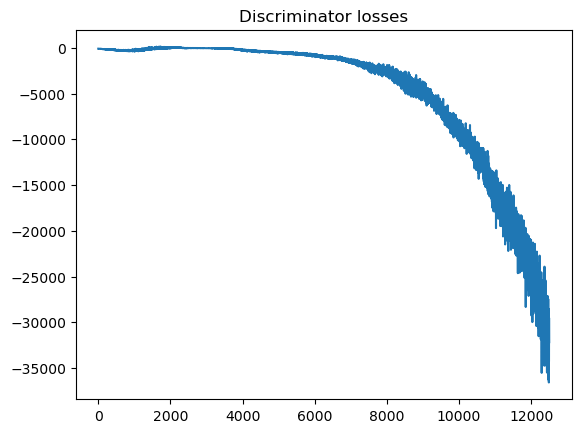

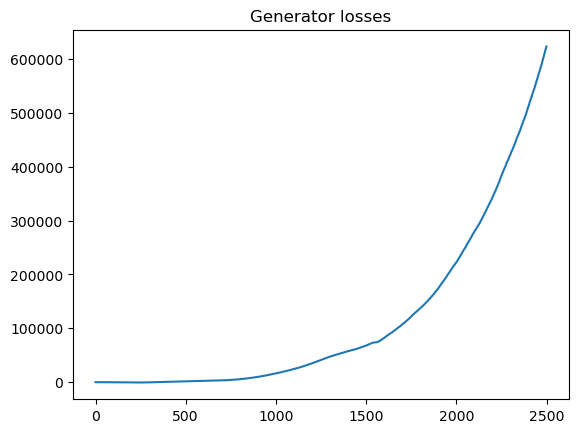

In [90]:
# print(model.generator.state_dict)

# path_to_load = pathlib.Path('.')
# model.load_states(output_path=path_to_load, postfix="_First_Gaussian_Blobs")

# print(model.generator.state_dict)
model.train(
    dataloader      = dataLoader,
    nepochs         = N_EPOCHS//10,
    ncritics        = N_CRITICS,
    sample_interval = SAMPLE_INTERVALS,
    save_interval   = SAVE_INTERVAL,
    load_states     = False,
    save_states     = True,
    verbose         = True,
    mlflow_run      = False,
    lr              = LEARNING_RATE/2,
    betas           = BETAS,
    l_gp       = L_GP,
    l_l1       = L_l1
)

In [ ]:
# model.save_states(pathlib.Path("."), "Fourth_multiple_Gaussian_Blobs")
# model.load_states(pathlib.Path("."), "_Third_multiple_Gaussian_Blobs")

In [23]:
for i in range(5):

    LATENT_DIM = 32 * 2**i
    model = DCGAN_WGP(
              identifier       = "123", 
              shape            = (1, 128,128), 
              latent_dim       = LATENT_DIM,
              cuda             = torch.cuda.is_available(),
              nconv_layer_gen  = N_CONV_LAYER_GEN,
              nconv_layer_disc = N_CONV_LAYER_DISC,
              kernel_size      = KERNEL_SIZE,
              padding          = PADDING,
              output_padding   = OUTPUT_PADDING,
              nconv_fcgen      = N_CONV_LAYER_GEN,
              nconv_fcdis      = N_CONV_LAYER_DISC,
              activation          = [
                  LinearFeature(1,1,True),
                  ScaledTanh(SCALE_A, SCALE_B)] # LinearFeature(5, 5, bias=True), 
            )
    
    model._update_latent_vector_sampler(lambda x, y: np.random.uniform(0, 1, (x, y)))
    
    model.train(
        dataloader      = dataLoader,
        nepochs         = N_EPOCHS*1,
        ncritics        = N_CRITICS,
        sample_interval = SAMPLE_INTERVALS,
        save_interval   = SAVE_INTERVAL,
        load_states     = False,
        save_states     = True,
        verbose         = True,
        mlflow_run      = False,
        lr              = LEARNING_RATE,
        betas           = BETAS,
        l_gp       = L_GP,
        l_l1       = L_l1
    )

    model.save_states(pathlib.Path("."), "Multiple_blobs_" + str(LATENT_DIM))
    SAVING_DIR = '/kaggle/working/datasets_for_Statistician/multiple_blobs_' + str(LATENT_DIM) + '/generated_data/'
    
    if not os.path.exists(pathlib.Path(SAVING_DIR)):
        os.makedirs(SAVING_DIR)
        print("Created:", SAVING_DIR)

    for n in range(BATCHES_TO_SAVE):
        z = model._get_latent_vector(BATCH_SIZE)
        # Generate a batch of images
        gen_imgs = model.generator(z).detach().cpu()
        
        for i in range(BATCH_SIZE):
            frame = gen_imgs.numpy()[i, 0, :, :]
            frame = frame - np.min(frame)
            frame = frame * 255 / np.max(frame)
            frame = frame.astype(np.uint8)

            # plt.imshow(frame)
            # plt.colorbar()
            # plt.title(str(np.max(frame)))
            # plt.show()

            img = Image.fromarray(frame)# .convert('RGB')
            print(f'\r{n*BATCH_SIZE + i + 1} / {BATCHES_TO_SAVE * BATCH_SIZE}', end='')
            img.save(SAVING_DIR + str((n * BATCH_SIZE) + i) + '.jpg')

AttributeError: 'DCGAN_WGP' object has no attribute '_update_latent_vector_sampler'

In [ ]:
SAVING_DIR = '/kaggle/working/datasets_for_Statistician/multiple_blobs_' + str(LATENT_DIM) + '/generated_data/'


## Plotting

z generated
Images generated
torch.Size([20, 1, 128, 128])
(128, 128, 1)


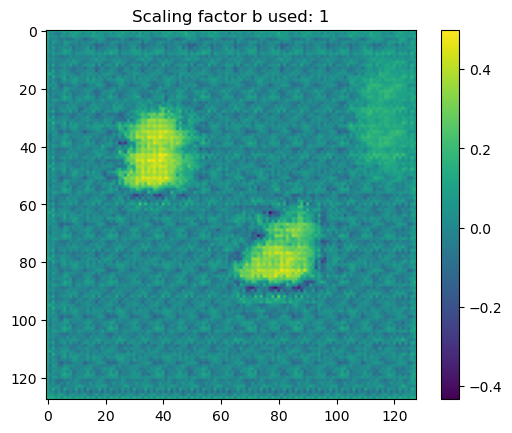

In [95]:
z = model._get_latent_vector(BATCH_SIZE)
# print(z.shape)
# z = torch.ones(size=(20,32), device="cuda")*1e10
# z[:, 0:10] = 0
print("z generated")
# Generate a batch of images
gen_imgs = model.generator(z).detach().cpu()
print("Images generated")
# gen_imgs = gen_imgs - gen_imgs.mean()
# print(gen_imgs.shape)
SCALE_B = 1
plt_image(gen_imgs)

In [18]:
# print(model._get_latent_vector(BATCH_SIZE))
z = model._get_latent_vector(BATCH_SIZE)
# print(len(d_losses))

In [ ]:
generator = model.generator
print(generator.)

torch.Size([20, 1, 128, 128])
torch.Size([20, 1, 128, 128])
(128, 128, 1)


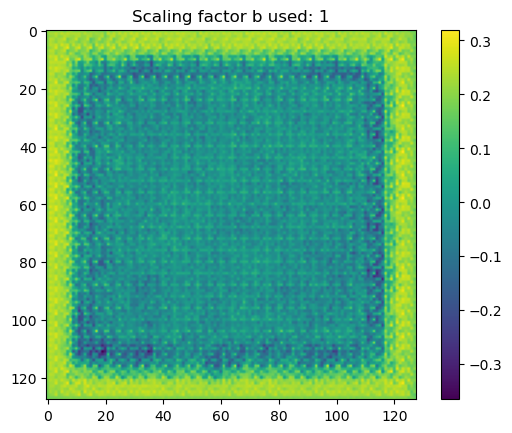

In [21]:
gen_imgs = model.generator(z)
print(gen_imgs.shape)

SCALE_B = 1
plt_image(gen_imgs)

In [ ]:
images, labels = next(iter(dataLoader))
plt_image(images, labels)

## Statistics dataset_creation

In [ ]:
if not os.path.exists(pathlib.Path(SAVING_DIR)):
    os.makedirs(SAVING_DIR)
    print("Created:", SAVING_DIR)
for n in range(BATCHES_TO_SAVE):
    z = model._get_latent_vector(BATCH_SIZE)
    # Generate a batch of images
    gen_imgs = model.generator(z).detach().cpu()
    
    for i in range(BATCH_SIZE):
        frame = gen_imgs.numpy()[i, 0, :, :]
        frame = frame - np.min(frame)
        frame = frame * 255 / np.max(frame)
        frame = frame.astype(np.uint8)

        # plt.imshow(frame)
        # plt.colorbar()
        # plt.title(str(np.max(frame)))
        # plt.show()

        img = Image.fromarray(frame)# .convert('RGB')
        print(f'\r{n*BATCH_SIZE + i + 1} / {BATCHES_TO_SAVE * BATCH_SIZE}', end='')
        img.save(SAVING_DIR + str((n * BATCH_SIZE) + i) + '.jpg')

In [ ]:
os.path.exists(pathlib.Path(SAVING_DIR))